In [1]:
%matplotlib inline
from mxnet import autograd, nd, gluon, init
from mxnet.gluon import loss as gloss, nn
import common as comm

In [5]:
def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    if keep_prob == 0:
        return X.zeros_like()
    mask = nd.random.uniform(0, 1, X.shape) < keep_prob;
    return mask * X / keep_prob

In [6]:
X = nd.arange(16).reshape((2, 8))

In [7]:
dropout(X, 0.5)


[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [16.  0.  0. 22. 24. 26.  0. 30.]]
<NDArray 2x8 @cpu(0)>

In [8]:
dropout(X, 1)


[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
<NDArray 2x8 @cpu(0)>

In [16]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens1))
b1 = nd.zeros(num_hiddens1)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens1, num_hiddens2))
b2 = nd.zeros(num_hiddens2)
W3 = nd.random.normal(scale=0.01, shape=(num_hiddens2, num_outputs))
b3 = nd.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

In [17]:
drop_prob1, drop_prob2 = 0.2, 0.5
def net(X):
    X = X.reshape((-1, num_inputs))
    H1 = (nd.dot(X, W1) + b1).relu()
    if autograd.is_training():
        H1 = dropout(H1, drop_prob1)
    H2 = (nd.dot(H1, W2) + b2)
    if autograd.is_training():
        H2 = dropout(H2, drop_prob2)
    return nd.dot(H2, W3) + b3

In [18]:
num_epochs, lr, batch_size = 20, 0.5, 256
loss = gloss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = comm.load_data_fashion_mnist(batch_size)
comm.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params, lr)

epoch 1, loss 1.4817, train acc 0.428, test acc 0.680
epoch 2, loss 0.7877, train acc 0.696, test acc 0.789
epoch 3, loss 0.6322, train acc 0.763, test acc 0.822
epoch 4, loss 0.5635, train acc 0.791, test acc 0.836
epoch 5, loss 0.5289, train acc 0.804, test acc 0.843
epoch 6, loss 0.5011, train acc 0.815, test acc 0.853
epoch 7, loss 0.4752, train acc 0.824, test acc 0.851
epoch 8, loss 0.4662, train acc 0.828, test acc 0.857
epoch 9, loss 0.4535, train acc 0.833, test acc 0.859
epoch 10, loss 0.4384, train acc 0.840, test acc 0.843
epoch 11, loss 0.4341, train acc 0.841, test acc 0.863
epoch 12, loss 0.4230, train acc 0.845, test acc 0.862
epoch 13, loss 0.4163, train acc 0.848, test acc 0.864
epoch 14, loss 0.4045, train acc 0.851, test acc 0.868
epoch 15, loss 0.3993, train acc 0.853, test acc 0.861
epoch 16, loss 0.3941, train acc 0.856, test acc 0.867
epoch 17, loss 0.3883, train acc 0.858, test acc 0.874
epoch 18, loss 0.3848, train acc 0.859, test acc 0.874
epoch 19, loss 0.37

In [19]:
#brief design
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'))
net.add(nn.Dropout(drop_prob1))
net.add(nn.Dense(256, activation='relu'))
net.add(nn.Dropout(drop_prob2))
net.add(nn.Dense(10))

In [22]:
net.initialize(init.Normal(sigma=0.01))

In [23]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {"learning_rate":lr})

In [24]:
comm.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              None, None, trainer)

epoch 1, loss 1.2414, train acc 0.525, test acc 0.784
epoch 2, loss 0.6018, train acc 0.774, test acc 0.812
epoch 3, loss 0.5058, train acc 0.815, test acc 0.847
epoch 4, loss 0.4622, train acc 0.832, test acc 0.856
epoch 5, loss 0.4384, train acc 0.840, test acc 0.866
epoch 6, loss 0.4109, train acc 0.851, test acc 0.870
epoch 7, loss 0.3934, train acc 0.856, test acc 0.872
epoch 8, loss 0.3851, train acc 0.861, test acc 0.872
epoch 9, loss 0.3689, train acc 0.866, test acc 0.872
epoch 10, loss 0.3580, train acc 0.871, test acc 0.880
epoch 11, loss 0.3518, train acc 0.872, test acc 0.881
epoch 12, loss 0.3447, train acc 0.875, test acc 0.885
epoch 13, loss 0.3387, train acc 0.875, test acc 0.884
epoch 14, loss 0.3272, train acc 0.879, test acc 0.878
epoch 15, loss 0.3236, train acc 0.882, test acc 0.882
epoch 16, loss 0.3222, train acc 0.881, test acc 0.877
epoch 17, loss 0.3135, train acc 0.885, test acc 0.887
epoch 18, loss 0.3089, train acc 0.886, test acc 0.889
epoch 19, loss 0.30

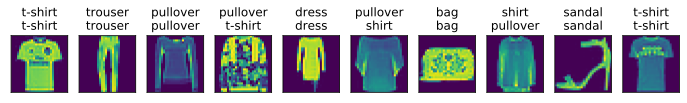

In [26]:
for X, y in test_iter:
    break

true_labels = comm.get_fashion_mnist_labels(y.asnumpy())
pred_labels = comm.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

comm.show_fashion_mnist(X[0:10], titles[0:10])